In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist, cdist
import scipy.linalg as lng
from numpy.linalg import slogdet
from sklearn.metrics import r2_score, mean_squared_error


## Load dataset, center to zeros, make some missing data

### This is sample AOD data from Los Angeles, size=(100,70)

The data includes 9 NaN data points. Manually create additional NaN data points. In the end, observed observations = 6297. The algorithm is tested on 694 "unobserved" data points.

N = 7000 = 6297 + 694 + 9

The original pyMRA code yields a performance of R^2 = 0.76 (slightly lower due to multiple M partitions).

In [ ]:
!git clone https://github.com/sjliu68/pyMRAsampleData.git

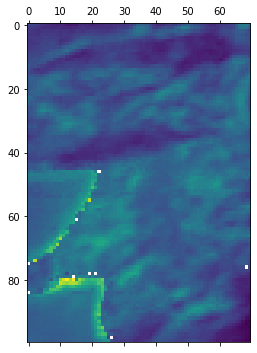

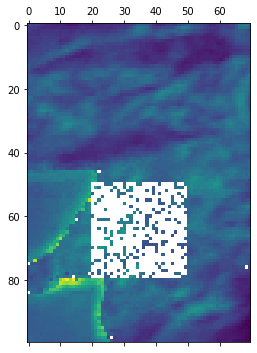

In [2]:
#%% load dataset
x1 = np.load('xlon2019.npy')
x2 = np.load('xlat2019.npy')
mean = np.load('mean2019.npy')   
mean -= 97
mean /= 10

imx1,imx2,imy1,imy2 = 670,770,190,260

data = mean[imx1:imx2,imy1:imy2]
data2 = copy.deepcopy(mean[imx1:imx2,imy1:imy2])
plt.matshow(data)
plt.show()


x1 = x1[imx1:imx2,imy1:imy2]
x2 = x2[imx1:imx2,imy1:imy2]
x1 -= x1.min()
x2 -= x2.min()
x1 /= x1.max()
x2 /= x2.max()


### make random train/test
np.random.seed(42)
_x = 50
_y = 20
n = 30
data[_x:_x+n,_y:_y+n] = np.nan
for i in range(n):
    for j in range(n):
        if np.random.rand()<0.2:
            data[_x+i,_y+j] = data2[_x+i,_y+j]

plt.matshow(data)
plt.show()

#%
idx = np.isnan(data)
train_y = data[~idx]
train_x1 = x1[~idx]
train_x2 = x2[~idx]


test_x1 = x1[idx]
test_x2 = x2[idx]
test_y = data2[idx]
test_X = np.asarray([test_x1,test_x2]).T
train_X = np.asarray([train_x1,train_x2]).T

idx2 = np.isnan(test_y)
test_y2 = test_y[~idx2]

### overwrite here, make all data including nan
train_y = data.reshape(-1,1)
idx = np.arange(train_y.shape[0])
train_X = np.asarray([x1.reshape(-1),x2.reshape(-1)]).T


## Base functions for calculating distance, covariance matrix

In [3]:
#%% base funtions
def dist(locs, locs2=np.array([]), circular=False):
    locs = locs if np.ndim(locs)==2 else np.reshape(locs, [len(locs), 1])
    if circular:
        if len(locs2):
            xv, yv = np.meshgrid(locs, locs2)
        else:
            xv, yv = np.meshgrid(locs, locs)
        m = np.minimum(xv, yv)
        M = np.maximum(xv, yv)
        dist = np.matrix(np.minimum(M - m, m + 1-M).T)
    else:
        if len(locs2):
            dist = np.matrix(cdist(locs, locs2))
        else:
            dist = np.matrix(squareform(pdist(locs)))
    return dist


def ExpCovFun(locs, locs2=np.array([]), l=1, circular=False):
    D = dist(locs, locs2, circular)
    covMat = np.exp(-D/l)
    return(covMat)

# cov = lambda _locs1, _locs2: ExpCovFun(_locs1, _locs2, l=2)
cov = lambda _locs1, _locs2: ExpCovFun(_locs1, _locs2, l=2) # guess l=2?


## The direct GP function

In [4]:
#%%
'''
X: two-dimensional locations. (N,2) -> can be expanded to multi dimensions
y: one-dimensional values. (N,1)

feasible when N < 1e4

'''
def directGP(X, y):
    R = 1e-4
    
    locs = X
    obs = np.matrix(y)
    obs_inds = np.where(np.logical_not(np.isnan(obs)))[0]
    
    N = len(locs) # not used in direct GP
    
    knots = locs[obs_inds] # all known values as knots
    kInds = obs_inds
    
    
    # prior
    B = cov(locs, knots)
    kInv = B[kInds, :]
    k = np.linalg.inv(kInv)
    kC = np.linalg.cholesky(k) # not used in direct GP
    
    
    # posterior
    obsInds = np.array(np.isfinite(obs)).ravel() # True/False
    
    H = np.matrix(np.eye(len(obs)))[obsInds,:]
    Rmat = np.matrix(R*np.eye(sum(obsInds)))
    
    HRinvH = (1/R) * H.T * H
    HRinvObs = H.T * (1/R) * obs[obsInds]
    omg = B.T * HRinvObs
    A = B.T * HRinvH * B
    
    kTil = np.matrix( lng.inv(kInv+A) )
    kTilInv = lng.inv(kTil)
    
    u = omg.T * kTil * omg + obs[obsInds].T * (1/R) * obs[obsInds] # not used in direct GP
    
    sgnTil, logdetTil = slogdet(kTilInv)
    sgn, logdet = slogdet(kInv)
    sgnR, logdetR = slogdet(Rmat)
    d = logdetTil - logdet + logdetR # not used in direct GP
    
    omgTil = omg - A * kTil * omg # not used in direct GP
    ATil = A - A*kTil*A # not used in direct GP
    BTil = B
    
    W,V = np.linalg.eigh(kTil)
    negInd = np.where(W<0)[0]
    W[negInd] = -W[negInd]
    kTilC = np.matrix(V) * np.matrix( np.diag(np.sqrt(W)) )
    
    mean = BTil * kTil * omg
    var = np.linalg.norm(BTil * kTilC, axis=1)**2
    
    return mean, var

## run the direct GP function based on the sample data

In [5]:
#%%
result = directGP(train_X, train_y)

## Test performance

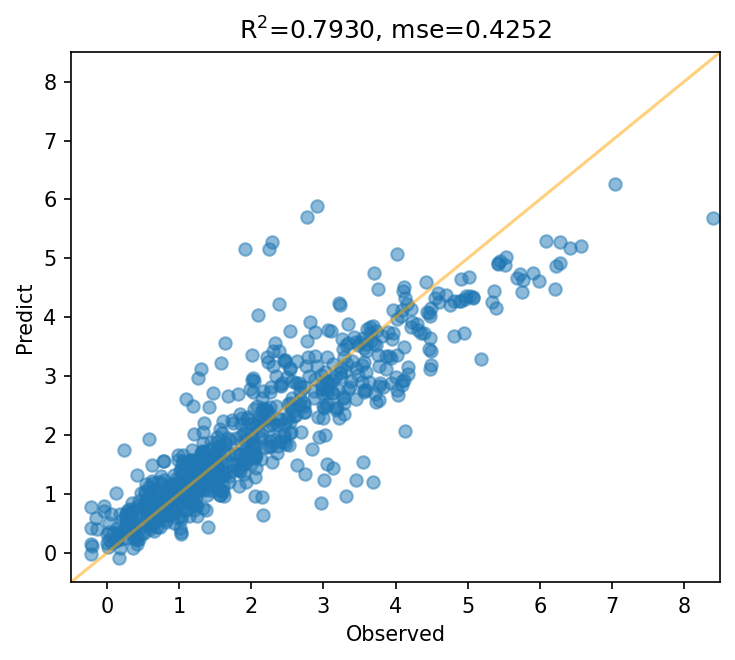

In [6]:
#%% test
ypre = result[0]
idx = np.where(np.isnan(train_y)) # test only on unknown locations
y2p = ypre[idx]
y2p = np.squeeze(np.asarray(y2p))
y2g = data2.reshape(-1,1)[idx]

# further cleanup. data originally contain NaN
idx2 = np.isnan(y2g)
y2g2 = y2g[~idx2]
y2p2 = y2p[~idx2]


# plot data
r2 = r2_score(y2g2, y2p2)
mse = mean_squared_error(y2g2, y2p2)

fig = plt.figure(figsize=(5,4.5),dpi=150)
plt.plot(np.arange(-5,10),np.arange(-5,10),c='orange',alpha=0.5)
plt.scatter(y2g,y2p,alpha=0.5)
plt.xlabel('Observed')
plt.ylabel('Predict')
plt.title('R$^2$='+f'{r2:.4f}'+', mse='+f'{mse:.4f}')
plt.xlim(-0.5,8.5)
plt.ylim(-0.5,8.5)
plt.tight_layout()
plt.show()